# Imports

In [1]:
# Data Processing
import pandas as pd 
import numpy as np 
import scipy.io 

import time
import random 

# Plotting 
from matplotlib import pyplot as plt 
import matplotlib.patches as mpatches
from matplotlib import style
import mpl_toolkits.mplot3d.axes3d as p3
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation, rc
from IPython.display import HTML

import matplotlib.image as mpimg 

plt.rcParams['animation.ffmpeg_path'] = "C:\\ffmpeg\\bin\\ffmpeg.exe"

import seaborn as sns

style.use('ggplot')

# Machine Learning 
import sklearn 

# Models 
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor 

# Model Selection 
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Data Preprocessing 
from sklearn.preprocessing import MinMaxScaler, Normalizer, StandardScaler, QuantileTransformer, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA 

# Saving models 
from sklearn.externals import joblib

C:\Users\vatsa\Miniconda3\envs\clustering_fl_v2\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


Now to get the data and do some basic processing. 

In [2]:
emitter_mat = scipy.io.loadmat("Emitter_cir_noise.mat")
cal_cir_mat = scipy.io.loadmat("cal_cir_noise.mat")
dataset_mat = scipy.io.loadmat("dataset_cir.mat")

emitter_df = pd.DataFrame(emitter_mat['Emitter_cir_noise'])
cal_cir_df = pd.DataFrame(cal_cir_mat['cal_cir_noise'])
dataset_df = pd.DataFrame(dataset_mat['dataset_cir'])

In [3]:
X_knn_pipeline = joblib.load('Pipelines/knn_pipeline.joblib')
X_nn_pipeline = joblib.load('Pipelines/nn_pipeline.joblib')
y_lat_pipeline = joblib.load('Pipelines/y_lab_pipeline.joblib')
y_long_pipeline = joblib.load('Pipelines/y_long_pipeline.joblib')

C:\Users\vatsa\Miniconda3\envs\clustering_fl_v2\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator Normalizer from version 0.22.1 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\vatsa\Miniconda3\envs\clustering_fl_v2\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator PCA from version 0.22.1 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\vatsa\Miniconda3\envs\clustering_fl_v2\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator Pipeline from version 0.22.1 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\vatsa\Miniconda3\envs\clustering_fl_v2\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator MinMaxScaler from version 0.22.

# Random Forest Estimation

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

Take one point of the calibration dataset (label, features)

`50.682052 N 10.939750 E` $\rightarrow$ `637034.48, 5616263.73`

Find entity that is closest to these coordinates in the calibration set. 

In [5]:
proper_easting = cal_cir_df[cal_cir_df[0] == 637034]
idx = None
min_dist = 1000

for index, row in proper_easting.iterrows():
    if abs(row[1] - 5616263) < min_dist:
        idx = index 
        min_dist = abs(row[1] - 5616263)

idx, min_dist

(843, 1.0)

In [6]:
sample = cal_cir_df.iloc[843:844,:]
sample_x = sample.iloc[:,3:]
sample_y = sample.iloc[:,0:2]

sample

,0,1,2,3,4,5,6,7,8,9,...,153,154,155,156,157,158,159,160,161,162
843,637034.0,5616264.0,1.5,1317.903805,39.550634,1317.719259,39.605691,1159.951257,23.806756,0.003493,...,0.091954,0.007388,0.036111,0.048278,-0.133208,0.011943,-0.039158,0.225639,-0.105103,0.133602


Add noise to the features to create 10000 different noisy samples for the same point 

In [7]:
def create_noisy_sample(X):
    noise = np.zeros(X.shape)
    for idx, column in enumerate(X):
        mu, sigma = X[column].mean(), X[column].std()
        noise[:, idx] = np.random.normal(0, 0.1*sigma, [X.shape[0], 1]).ravel()

    return noise 

X_train = dataset_df.iloc[:, 3:]
noise = create_noisy_sample(X_train)

In [8]:
noise_df = pd.DataFrame(noise, columns=list(range(3, 163))).iloc[:10000]
noise_df.head()

,3,4,5,6,7,8,9,10,11,12,...,153,154,155,156,157,158,159,160,161,162
0,-8.160802,1.629046,135.555487,1.519650,394.942374,0.414543,257.742718,-3.325026,95.277634,1.110001,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-9.223264,0.946852,27.223746,-1.252949,191.864503,-0.644777,218.080705,-1.369855,-146.178351,-1.601342,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,28.865656,-0.172010,-42.393757,0.329559,228.279556,2.206656,83.448952,5.039125,347.924532,0.427927,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-61.817012,0.096675,-111.074042,0.701029,-162.040536,-0.061434,3.205658,0.394928,34.642906,1.092944,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-100.897445,1.362494,-265.167011,-6.220293,2.033406,-1.648772,-79.110513,-3.103716,-255.074030,0.295707,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
sample_x_repl = sample_x.append([sample_x.iloc[0, :]]*9999, ignore_index=True)
sample_y_repl = sample_y.append([sample_y.iloc[0, :]]*9999, ignore_index=True)

sample_y_repl.head()

,0,1
0,637034.0,5616264.0
1,637034.0,5616264.0
2,637034.0,5616264.0
3,637034.0,5616264.0
4,637034.0,5616264.0


In [10]:
noisy_sample_df = sample_x_repl + noise_df
print('Noisy Sample Size: ', noisy_sample_df.shape)
noisy_sample_df.head()

Noisy Sample Size:  (10000, 160)


,3,4,5,6,7,8,9,10,11,12,...,153,154,155,156,157,158,159,160,161,162
0,1309.743003,41.179680,1453.274746,41.125341,1554.893631,24.221299,257.746211,-3.461772,95.236890,1.073612,...,0.091954,0.007388,0.036111,0.048278,-0.133208,0.011943,-0.039158,0.225639,-0.105103,0.133602
1,1308.680541,40.497486,1344.943005,38.352742,1351.815760,23.161979,218.084198,-1.506601,-146.219095,-1.637731,...,0.091954,0.007388,0.036111,0.048278,-0.133208,0.011943,-0.039158,0.225639,-0.105103,0.133602
2,1346.769461,39.378623,1275.325502,39.935249,1388.230814,26.013412,83.452444,4.902379,347.883788,0.391538,...,0.091954,0.007388,0.036111,0.048278,-0.133208,0.011943,-0.039158,0.225639,-0.105103,0.133602
3,1256.086793,39.647308,1206.645217,40.306720,997.910721,23.745322,3.209151,0.258182,34.602162,1.056554,...,0.091954,0.007388,0.036111,0.048278,-0.133208,0.011943,-0.039158,0.225639,-0.105103,0.133602
4,1217.006360,40.913127,1052.552248,33.385398,1161.984663,22.157984,-79.107020,-3.240462,-255.114774,0.259318,...,0.091954,0.007388,0.036111,0.048278,-0.133208,0.011943,-0.039158,0.225639,-0.105103,0.133602


We now have 10000 noisy samples for a single point. 

In [11]:
# Convert sample features and labels to array to pass into random forest algorithm 
noisy_samples = np.array(noisy_sample_df)
y_samples = np.array(sample_y_repl)

In [12]:
y_samples_lat = y_lat_pipeline.transform(y_samples[:, 0].reshape(-1, 1))
y_samples_long = y_long_pipeline.transform(y_samples[:, 1].reshape(-1, 1))
y_samples = np.concatenate((y_samples_lat, y_samples_long), axis=1)

In [13]:
def error_metrics(model, X_test, y_test):
    y_pred = model.predict(X_test)
 
    y_pred_lat = y_lat_pipeline.inverse_transform(y_pred[:, 0].reshape(-1,1))
    y_pred_long = y_long_pipeline.inverse_transform(y_pred[:, 1].reshape(-1,1))
    y_test_lat = y_lat_pipeline.inverse_transform(y_test[:, 0].reshape(-1,1))
    y_test_long = y_long_pipeline.inverse_transform(y_test[:, 1].reshape(-1,1))
    
    lat_rmse = np.sqrt(mean_squared_error(y_test_lat, y_pred_lat))
    long_rmse = np.sqrt(mean_squared_error(y_test_long, y_pred_long))
    error_dist = np.sqrt(lat_rmse**2 + long_rmse**2)

    return lat_rmse, long_rmse, error_dist

def plot_2D_predictions(model, range_beg, range_end, X_test, y_test):
    
    fig, ax = plt.subplots(figsize=(10, 10))
    
    y_pred = model.predict(X_test)
    y_pred_lat = y_lat_pipeline.inverse_transform(y_pred[:, 0].reshape(-1,1))
    y_pred_long = y_long_pipeline.inverse_transform(y_pred[:, 1].reshape(-1,1))
    y_test_lat = y_lat_pipeline.inverse_transform(y_test[:, 0].reshape(-1,1))
    y_test_long = y_long_pipeline.inverse_transform(y_test[:, 1].reshape(-1,1))
    
    plt.xlabel('Latitude')
    plt.ylabel('Longitude')
    
    y_lat = y_lat_pipeline.inverse_transform(y_test[:, 0].reshape(-1,1))
    y_long = y_long_pipeline.inverse_transform(y_test[:, 1].reshape(-1,1))
    
    plt.xlim(int(y_lat.min()) - 150, int(y_lat.max()) + 150)
    plt.ylim(int(y_long.min()) - 150, int(y_long.max()) + 150)

    img = plt.imread('base.png')
    ax.imshow(img, extent=[636500, 638035, 5615950, 5617485], alpha=0.2)

    ax.plot([y_pred_lat.squeeze(),y_test_lat.squeeze()], 
             [y_pred_long.squeeze(),y_test_long.squeeze()], color='red', marker='.')

    ax.plot(y_pred_lat[range_beg:range_end], y_pred_long[range_beg:range_end], 'g.')
    ax.plot(y_test_lat[range_beg:range_end], y_test_long[range_beg:range_end], 'b.')
    plt.show()
    
    return np.concatenate([y_pred_lat, y_pred_long], axis=1)

C:\Users\vatsa\Miniconda3\envs\clustering_fl_v2\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.22.1 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\vatsa\Miniconda3\envs\clustering_fl_v2\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.22.1 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


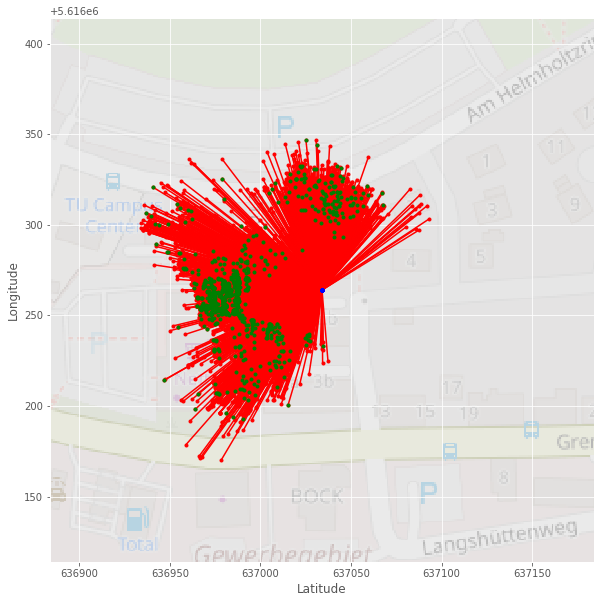

In [14]:
rf_reg = joblib.load('Regression Models/rf_vanilla.sav')
lat_rmse, long_rmse, error_dist = error_metrics(rf_reg, noisy_samples, y_samples)
y_preds = plot_2D_predictions(model=rf_reg, X_test=noisy_samples, y_test=y_samples, range_beg=1, range_end=1000)

Remove outliers using interquartile range. (Q1 - 1.5IQR, Q3 + 1.5IQR) 

In [15]:
y_preds_df = pd.DataFrame(y_preds)

def iqr_outlier(y_preds_df):
    lat_q1 = y_preds_df[0].quantile(0.25)
    lat_q3 = y_preds_df[0].quantile(0.75)
    lat_IQR = lat_q3 - lat_q1

    long_q1 = y_preds_df[1].quantile(0.25)
    long_q3 = y_preds_df[1].quantile(0.75)
    long_IQR = long_q3 - long_q1

    is_outlier = ((y_preds_df[0] < lat_q1 - 1.5 * lat_IQR) | 
                 (y_preds_df[0] > lat_q3 + 1.5 * lat_IQR) |
                 (y_preds_df[1] < long_q1 - 1.5 * long_IQR) | 
                 (y_preds_df[1] > long_q3 + 1.5 * long_IQR))
    
    clean_y_preds_df = y_preds_df[~is_outlier]
    outliers_df = y_preds_df[is_outlier]

    print("IQR Clean Shape: ", clean_y_preds_df.shape)
    clean_y_preds = np.array(clean_y_preds_df)    
    outliers = np.array(outliers_df)
    return clean_y_preds, outliers  

def zscore_outlier(y_preds_df):
    lat_mean = y_preds_df[0].mean()
    lat_std = y_preds_df[0].std()

    long_mean = y_preds_df[1].mean()
    long_std = y_preds_df[1].std()

    lat_cutoff = 2 * lat_std
    long_cutoff = 2 * long_std 
    
    lat_bounds = [lat_mean - lat_cutoff, lat_mean + lat_cutoff]
    long_bounds = [long_mean - long_cutoff, long_mean + long_cutoff]
    
    is_outlier = ((y_preds_df[0] < lat_bounds[0]) | 
                 (y_preds_df[0] > lat_bounds[1]) |
                 (y_preds_df[1] < long_bounds[0]) |
                 (y_preds_df[1] > long_bounds[1]))
    
    clean_y_preds_df = y_preds_df[~is_outlier]
    
    outliers_df = y_preds_df[is_outlier]
    
    print("Z-Score Clean Shape: ", clean_y_preds_df.shape)
    print("Mean Coords: ", lat_mean, long_mean)
    clean_y_preds = np.array(clean_y_preds_df)
    outliers = np.array(outliers_df)
    return clean_y_preds, outliers, (lat_mean, long_mean)


iqr_clean_y_preds, iqr_outliers = iqr_outlier(y_preds_df)
z_clean_y_preds, z_outliers, estimation_mean = zscore_outlier(y_preds_df)

IQR Clean Shape:  (7870, 2)
Z-Score Clean Shape:  (8581, 2)
Mean Coords:  636990.4830221666 5616263.067531554


In [16]:
# Code: https://stackoverflow.com/questions/20126061/creating-a-confidence-ellipses-in-a-sccatterplot-using-matplotlib

def eigsorted(cov):
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    return vals[order], vecs[:,order]

raw_x, raw_y = y_preds[:, 0], y_preds[:, 1]

iqr_xc, iqr_yc = iqr_clean_y_preds[:, 0], iqr_clean_y_preds[:, 1]
iqr_xo, iqr_yo = iqr_outliers[:, 0], iqr_outliers[:, 1]

z_xc, z_yc = z_clean_y_preds[:, 0], z_clean_y_preds[:, 1]
z_xo, z_yo = z_outliers[:, 0], z_outliers[:, 1]

nstd = 2

def create_confidence_ellipse(x, y, xo, yo, title, ax, color='green'):
    img = plt.imread('base.png')
    ax.imshow(img, extent=[636500, 638035, 5615950, 5617485], alpha=0.2)

    cov = np.cov(x, y)
    vals, vecs = eigsorted(cov)
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))
    w, h = 2 * nstd * np.sqrt(vals)
    ell = Ellipse(xy=(np.mean(x), np.mean(y)),
                  width=w, height=h,
                  angle=theta, color='black')
    ell.set_facecolor('none')
    ax.add_artist(ell)

    plt.xlim(636500, 638000)
    plt.ylim(5615950, 5617350)

    plt.scatter(x, y, s=2, c=color)
    plt.scatter(xo, yo, s=2, c='red')

    y_lat_sample = y_lat_pipeline.inverse_transform(y_samples[:, 0].reshape(-1,1))
    y_long_sample = y_long_pipeline.inverse_transform(y_samples[:, 1].reshape(-1,1))

    plt.scatter(y_lat_sample, y_long_sample, s=250, c='blue', marker='+')
    plt.title(title)
    plt.show()
    
    return cov

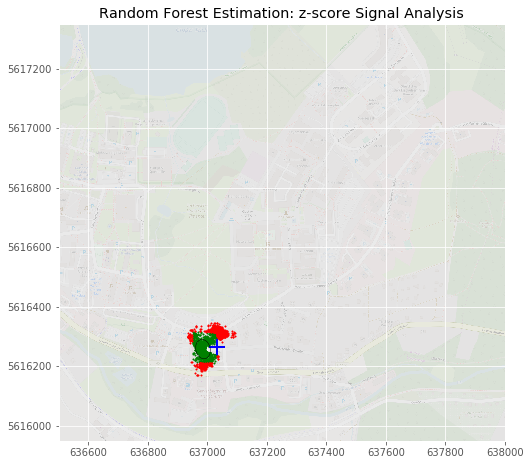

In [17]:
fig, ax = plt.subplots(figsize=(8, 8))
estimation_cov = create_confidence_ellipse(z_xc, z_yc, z_xo, z_yo,  
                          'Random Forest Estimation: z-score Signal Analysis',
                           ax)

In [18]:
print(y_preds_df[0].min(), y_preds_df[0].max(), y_preds_df[0].max() - y_preds_df[0].min())
print(y_preds_df[1].min(), y_preds_df[1].max(), y_preds_df[1].max() - y_preds_df[1].min())

636933.9308021596 637093.2702969692 159.33949480962474
5616169.963900165 5616346.948216596 176.98431643098593


# Measurement Estimation

In [19]:
matlab_13 = scipy.io.loadmat("matlab_13_01_02.mat")
matlab_13

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Wed Jan 30 15:49:15 2019',
 '__version__': '1.0',
 '__globals__': [],
 'E': array([[ 637024, 5616274,     498]]),
 'P1': array([[6.36892017e+05, 5.61646982e+06, 5.01149888e+02],
        [6.37124493e+05, 5.61636777e+06, 6.97502759e+02],
        [6.37129303e+05, 5.61634876e+06, 6.92778737e+02],
        ...,
        [6.37167985e+05, 5.61612714e+06, 5.14209909e+02],
        [6.37132764e+05, 5.61610084e+06, 5.14492175e+02],
        [6.37229355e+05, 5.61612674e+06, 5.15958244e+02]]),
 'P2': array([[6.36892017e+05, 5.61646982e+06, 5.01149888e+02],
        [6.37136889e+05, 5.61636409e+06, 3.00098885e+02],
        [6.37141352e+05, 5.61634484e+06, 3.06327576e+02],
        ...,
        [6.37167985e+05, 5.61612714e+06, 5.14209909e+02],
        [6.37132764e+05, 5.61610084e+06, 5.14492175e+02],
        [6.37229355e+05, 5.61612674e+06, 5.15958244e+02]]),
 'St': array([[6.37376212e+05, 5.61629139e+06, 5.16900000e+02],
        [6.3516

In [20]:
p1_df = pd.DataFrame(matlab_13['P1'])
p2_df = pd.DataFrame(matlab_13['P2'])

In [21]:
measurements_df = p1_df # pd.DataFrame(pd.concat([p1_df, p2_df]))
measurements_df.drop([2], axis=1, inplace=True)
print(measurements_df.shape)
measurements_df.head()

(87704, 2)


,0,1
0,636892.017438,5.616470e+06
1,637124.492951,5.616368e+06
2,637129.303353,5.616349e+06
3,637166.334995,5.616322e+06
4,637169.576648,5.616339e+06


Get outliers and the clean coordinates. 

In [22]:
m_clean_coords, m_outliers, measurements_mean = zscore_outlier(measurements_df)

Z-Score Clean Shape:  (81282, 2)
Mean Coords:  637098.9240909778 5616152.895293407


There are about 162,564 points that are not outliers. 

In [23]:
m_xc, m_yc = m_clean_coords[:, 0], m_clean_coords[:, 1]
m_xo, m_yo = m_outliers[:, 0], m_outliers[:, 1]

In [24]:
np.cov(m_xc, m_yc)
print((np.std(m_xc), np.std(m_yc)))
print((np.std(z_xc), np.std(z_yc)))

(184.31438455616458, 100.6556608632472)
(12.390566584717307, 16.20574298074089)


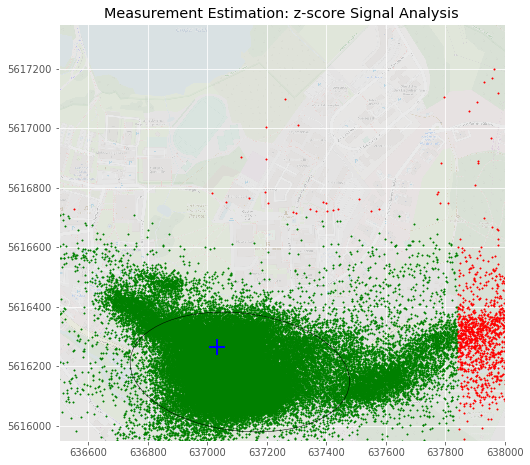

In [25]:
fig, ax = plt.subplots(figsize=(8, 8))
measurements_cov = create_confidence_ellipse(m_xc, m_yc, m_xo, m_yo, 
                          'Measurement Estimation: z-score Signal Analysis',
                           ax)

# Joint Estimation using ICI Analysis 

In [26]:
"""
Inverse covariance intersection according to http://discovery.ucl.ac.uk/135541/
"""

from enum import Enum
from scipy.optimize import fminbound
from numpy.linalg import inv, det
import numpy as np


class PerformanceCriterion(Enum):
    TRACE = 1,
    DETERMINANT = 2


class InverseCovarianceIntersection(object):
    def __init__(self, performance_criterion=PerformanceCriterion.TRACE):
        self.performance_criterion = det if performance_criterion == PerformanceCriterion.DETERMINANT else np.trace
        self.algorithm_name = "Inverse Covariance Intersection"
        self.algorithm_abbreviation = "ICI"

    def fuse(self, mean_a, cov_a, mean_b, cov_b):
        omega = self.optimize_omega(cov_a, cov_b)
        cov = inv(inv(cov_a) + inv(cov_b) - inv(np.multiply(omega, cov_a) + np.multiply(1 - omega, cov_b)))
        T = inv(np.multiply(omega, cov_a) + np.multiply(1-omega, cov_b))
        K = np.dot(cov, inv(cov_a) - np.multiply(omega, T))
        L = np.dot(cov, inv(cov_b) - np.multiply(1 - omega, T))
        mean = np.dot(K, mean_a) + np.dot(L, mean_b)
        return mean, cov

    def optimize_omega(self, cov_a, cov_b):
        def optimize_fn(omega):
            return self.performance_criterion(inv(inv(cov_a) + inv(cov_b) - inv(np.multiply(omega, cov_a) + np.multiply(1 - omega, cov_b))))
        return fminbound(optimize_fn, 0, 1)

Extract the mean and covariance from the estimations and the measurements. 

In [27]:
print('Estimation Mean: {} \nEstimation Covariance: {}'.format(estimation_mean, estimation_cov))
print('Measurements Mean: {} \nMeasurements Covariance: {}'.format(measurements_mean, measurements_cov))

Estimation Mean: (636990.4830221666, 5616263.067531554) 
Estimation Covariance: [[153.54403378 -26.339341  ]
 [-26.339341   262.65671466]]
Measurements Mean: (637098.9240909778, 5616152.895293407) 
Measurements Covariance: [[33972.21030922 -2896.4110742 ]
 [-2896.4110742  10131.68671241]]


In [28]:
ici = InverseCovarianceIntersection()
joint_mean, joint_cov = ici.fuse(estimation_mean, estimation_cov,
                                measurements_mean, measurements_cov)
print('Joint Mean: {} \nJoint Covariance: {}'.format(joint_mean, joint_cov))

Joint Mean: [ 636990.4830222  5616263.06753124] 
Joint Covariance: [[153.54403693 -26.33934303]
 [-26.33934303 262.65674447]]


In [29]:
def create_joint_ellipse(ax):
    img = plt.imread('base.png')
    ax.imshow(img, extent=[636500, 638035, 5615950, 5617485], alpha=0.2)

    cov = joint_cov
    vals, vecs = eigsorted(cov)
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))
    w, h = 2 * nstd * np.sqrt(vals)
    ell = Ellipse(xy=(joint_mean[0], joint_mean[1]),
                  width=w, height=h,
                  angle=theta, color='black')
    ell.set_facecolor('none')
    ax.add_artist(ell)

    plt.xlim(joint_mean[0] - 300, joint_mean[0] + 300)
    plt.ylim(joint_mean[1] - 300, joint_mean[1] + 300)

    # plt.xlim(636500, 638000)
    # plt.ylim(5615950, 5617350)

    plt.scatter(joint_mean[0], joint_mean[1], s=2, c='blue')

    y_lat_sample = y_lat_pipeline.inverse_transform(y_samples[:, 0].reshape(-1,1))
    y_long_sample = y_long_pipeline.inverse_transform(y_samples[:, 1].reshape(-1,1))

    plt.scatter(y_lat_sample, y_long_sample, s=250, c='blue', marker='+')
    plt.title('Joint Estimation Confidence Ellipse')
    plt.show()


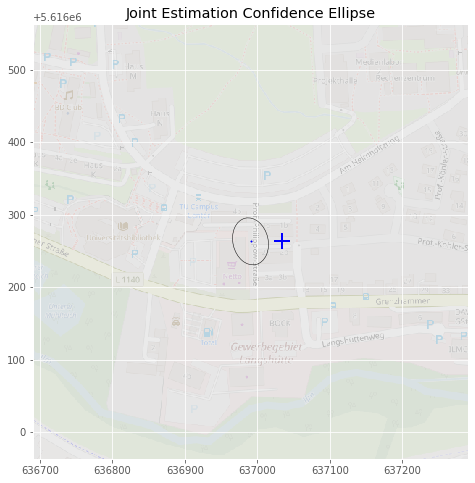

In [30]:
fig, ax = plt.subplots(figsize=(8, 8))
create_joint_ellipse(ax)

Plot all three graphics side by side. 

Text(0.5, 1.0, 'Joint Estimation Confidence Ellipse')

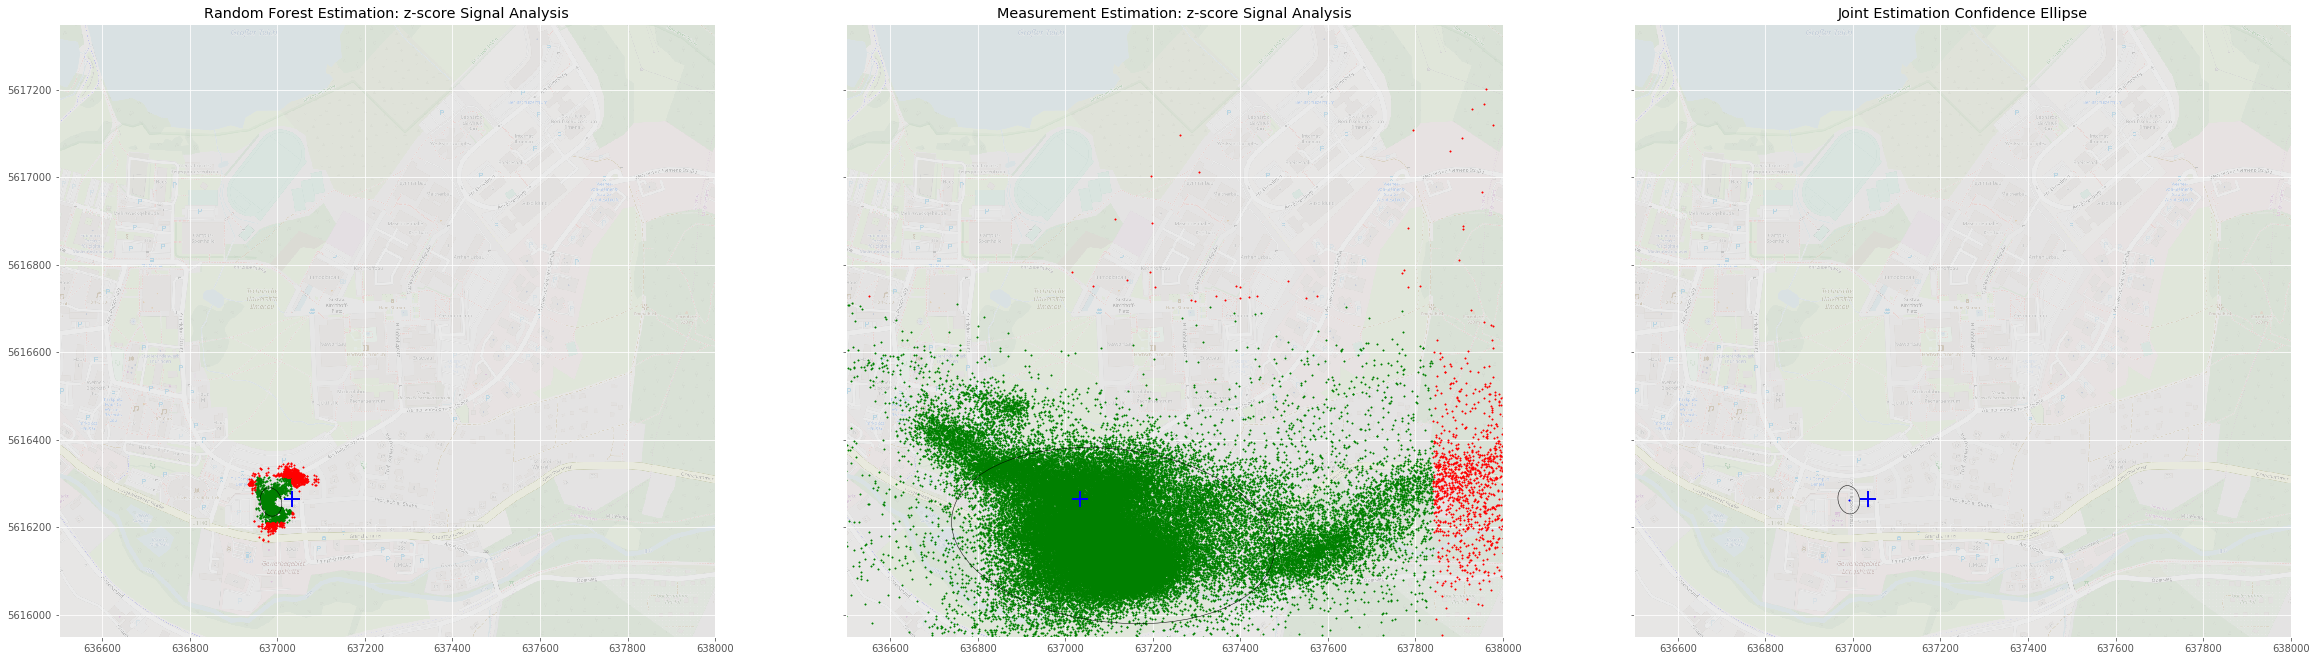

In [31]:
fig, axes = plt.subplots(1, 3, figsize=(40, 20), sharex=True, sharey=True)
color = 'green'
img = plt.imread('base.png')

plt.sca(axes[0])
plt.imshow(img, extent=[636500, 638035, 5615950, 5617485], alpha=0.2)
cov = np.cov(z_xc, z_yc)
vals, vecs = eigsorted(cov)
theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))
w, h = 2 * nstd * np.sqrt(vals)
ell = Ellipse(xy=(np.mean(z_xc), np.mean(z_yc)),
              width=w, height=h,
              angle=theta, color='black')
ell.set_facecolor('none')
axes[0].add_artist(ell)
plt.xlim(636500, 638000)
plt.ylim(5615950, 5617350)
plt.scatter(z_xc, z_yc, s=2, c=color)
plt.scatter(z_xo, z_yo, s=2, c='red')
y_lat_sample = y_lat_pipeline.inverse_transform(y_samples[:, 0].reshape(-1,1))
y_long_sample = y_long_pipeline.inverse_transform(y_samples[:, 1].reshape(-1,1))
plt.scatter(y_lat_sample, y_long_sample, s=250, c='blue', marker='+')
plt.title('Random Forest Estimation: z-score Signal Analysis')


plt.sca(axes[1])
plt.imshow(img, extent=[636500, 638035, 5615950, 5617485], alpha=0.2)
cov = np.cov(m_xc, m_yc)
vals, vecs = eigsorted(cov)
theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))
w, h = 2 * nstd * np.sqrt(vals)
ell = Ellipse(xy=(np.mean(m_xc), np.mean(m_yc)),
              width=w, height=h,
              angle=theta, color='black')
ell.set_facecolor('none')
axes[1].add_artist(ell)
plt.xlim(636500, 638000)
plt.ylim(5615950, 5617350)
plt.scatter(m_xc, m_yc, s=2, c=color)
plt.scatter(m_xo, m_yo, s=2, c='red')
y_lat_sample = y_lat_pipeline.inverse_transform(y_samples[:, 0].reshape(-1,1))
y_long_sample = y_long_pipeline.inverse_transform(y_samples[:, 1].reshape(-1,1))
plt.scatter(y_lat_sample, y_long_sample, s=250, c='blue', marker='+')
plt.title('Measurement Estimation: z-score Signal Analysis')

plt.sca(axes[2])
plt.imshow(img, extent=[636500, 638035, 5615950, 5617485], alpha=0.2)
cov = joint_cov
vals, vecs = eigsorted(cov)
theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))
w, h = 2 * nstd * np.sqrt(vals)
ell = Ellipse(xy=(joint_mean[0], joint_mean[1]),
              width=w, height=h,
              angle=theta, color='black')
ell.set_facecolor('none')
axes[2].add_artist(ell)

# plt.xlim(joint_mean[0] - 300, joint_mean[0] + 300)
# plt.ylim(joint_mean[1] - 300, joint_mean[1] + 300)

plt.xlim(636500, 638000)
plt.ylim(5615950, 5617350)

plt.scatter(joint_mean[0], joint_mean[1], s=2, c='blue')

y_lat_sample = y_lat_pipeline.inverse_transform(y_samples[:, 0].reshape(-1,1))
y_long_sample = y_long_pipeline.inverse_transform(y_samples[:, 1].reshape(-1,1))

plt.scatter(y_lat_sample, y_long_sample, s=250, c='blue', marker='+')
plt.title('Joint Estimation Confidence Ellipse')